In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

train_file_path = '/content/drive/MyDrive/Dataz/train.csv'
test_file_path = '/content/drive/MyDrive/Dataz/test.csv'

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

Mounted at /content/drive


In [3]:
# Set random see for reporducibility
torch.manual_seed(42)

In [4]:
# check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
df = train_df.copy()

In [6]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


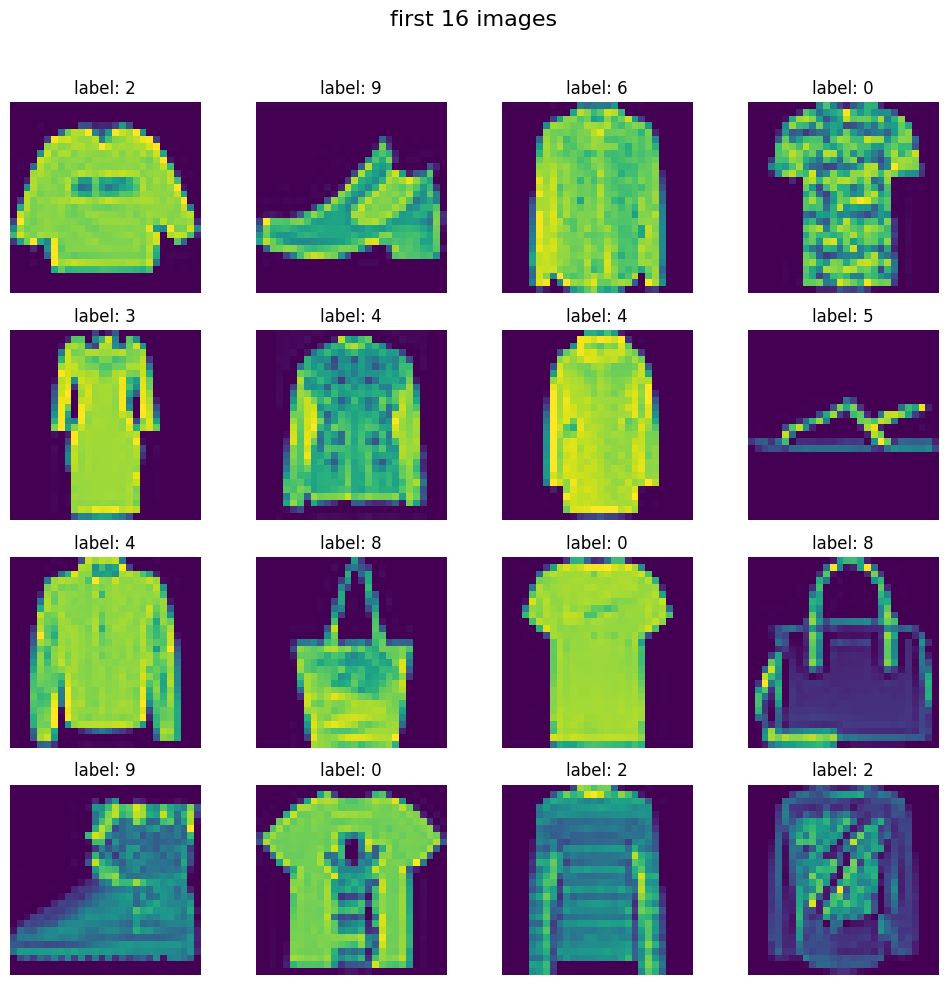

In [7]:
# create a 4 x 4
fig, axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("first 16 images", fontsize=16)

# plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img =df.iloc[i,1:].values.reshape(28,28) # reshape to 28 x 28
  ax.imshow(img) #Display in grayscale
  ax.axis('off') # Turn off axis
  ax.set_title(f"label: {df.iloc[i,0]}") # Set title to the first column

plt.tight_layout(rect=[0,0,1,0.96])  #adjust layout to fit the title
plt.show()

In [8]:
# train test split
X = df.iloc[:, 1:].values
y = df.iloc[:,0].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state = 42)

In [10]:
# scaling the features
X_train = X_train/255.0
X_test = X_test/255.0

In [11]:
# create custom dataset class
class CustomDataset(Dataset):
  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

In [12]:
# create train dataset object
train_dataset = CustomDataset(X_train, y_train)

In [13]:
len(train_dataset)

48000

In [14]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2275,
         0.5333, 0.0000, 0.0

In [15]:
# create test dataset object
test_dataset = CustomDataset(X_test, y_test)

In [16]:
 # create train and test loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory = True)

In [17]:
# define NN class
class MyNN(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )

  def forward(self, x):
    return self.model(x)

In [18]:
# set learning rate and epochs
epochs = 100
learning_rate = 0.1

In [19]:
# instatiate the model
model = MyNN(X_train.shape[1])
model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
# training loop
for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to GPU
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)
    loss = criterion(outputs, batch_labels)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()


  avg_loss = total_epoch_loss / len(train_loader)
  print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

Epoch [1/100], Loss: 0.6353
Epoch [2/100], Loss: 0.4305
Epoch [3/100], Loss: 0.3861
Epoch [4/100], Loss: 0.3585
Epoch [5/100], Loss: 0.3376
Epoch [6/100], Loss: 0.3228
Epoch [7/100], Loss: 0.3079
Epoch [8/100], Loss: 0.2950
Epoch [9/100], Loss: 0.2855
Epoch [10/100], Loss: 0.2747
Epoch [11/100], Loss: 0.2683
Epoch [12/100], Loss: 0.2581
Epoch [13/100], Loss: 0.2494
Epoch [14/100], Loss: 0.2444
Epoch [15/100], Loss: 0.2386
Epoch [16/100], Loss: 0.2316
Epoch [17/100], Loss: 0.2256
Epoch [18/100], Loss: 0.2203
Epoch [19/100], Loss: 0.2121
Epoch [20/100], Loss: 0.2096
Epoch [21/100], Loss: 0.2062
Epoch [22/100], Loss: 0.1999
Epoch [23/100], Loss: 0.1953
Epoch [24/100], Loss: 0.1931
Epoch [25/100], Loss: 0.1876
Epoch [26/100], Loss: 0.1837
Epoch [27/100], Loss: 0.1802
Epoch [28/100], Loss: 0.1733
Epoch [29/100], Loss: 0.1705
Epoch [30/100], Loss: 0.1704
Epoch [31/100], Loss: 0.1670
Epoch [32/100], Loss: 0.1637
Epoch [33/100], Loss: 0.1623
Epoch [34/100], Loss: 0.1572
Epoch [35/100], Loss: 0

In [21]:
# set model to eval mode
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [22]:
# evaluation code
total = 0
correct = 0
with torch.no_grad():
  for batch_features, batch_labels in test_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)
    _, predicted = torch.max(outputs.data, 1)
    total += batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 88.98%


In [23]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)
    _, predicted = torch.max(outputs, 1)
    total += batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 98.25%


evaluation on test data is 88.98% <br>
evaluation of train data is 98.25% <br>
So, there is overfitting

# **Optimizing Neural Network**
- Adding more data
- Reducing the complexity of NN architecture
- Regularization
- Dropouts
- Data Augmentation
- Batch Normalization
- Early stopping


### In this session we use Regularization, Dropouts and Batch Normalization

In [24]:
# Dropouts
class MyNN(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(64, 10)
    )
  def forward(self, x):
    return self.model(x)

In [25]:
learning_rate = 0.01
epochs = 100

In [26]:
model = MyNN(X_train.shape[1])
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4) #L2 Regularization weigh_Decay

In [27]:
# training loop
for epoch in range(epochs):
  total_epoch_loss = 0
  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss / len(train_loader)
  print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')


Epoch [1/100], Loss: 0.8145
Epoch [2/100], Loss: 0.5614
Epoch [3/100], Loss: 0.5123
Epoch [4/100], Loss: 0.4810
Epoch [5/100], Loss: 0.4660
Epoch [6/100], Loss: 0.4443
Epoch [7/100], Loss: 0.4275
Epoch [8/100], Loss: 0.4214
Epoch [9/100], Loss: 0.4071
Epoch [10/100], Loss: 0.3998
Epoch [11/100], Loss: 0.3948
Epoch [12/100], Loss: 0.3892
Epoch [13/100], Loss: 0.3822
Epoch [14/100], Loss: 0.3756
Epoch [15/100], Loss: 0.3714
Epoch [16/100], Loss: 0.3660
Epoch [17/100], Loss: 0.3578
Epoch [18/100], Loss: 0.3521
Epoch [19/100], Loss: 0.3524
Epoch [20/100], Loss: 0.3458
Epoch [21/100], Loss: 0.3446
Epoch [22/100], Loss: 0.3403
Epoch [23/100], Loss: 0.3377
Epoch [24/100], Loss: 0.3349
Epoch [25/100], Loss: 0.3277
Epoch [26/100], Loss: 0.3294
Epoch [27/100], Loss: 0.3232
Epoch [28/100], Loss: 0.3226
Epoch [29/100], Loss: 0.3180
Epoch [30/100], Loss: 0.3156
Epoch [31/100], Loss: 0.3118
Epoch [32/100], Loss: 0.3081
Epoch [33/100], Loss: 0.3078
Epoch [34/100], Loss: 0.3084
Epoch [35/100], Loss: 0

In [28]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [29]:
# evaluation on test data
total = 0
correct = 0
with torch.no_grad():
  for batch_features, batch_labels in test_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)
    outputs = model(batch_features)
    _, predicted = torch.max(outputs.data, 1)
    total += batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 89.44%


In [30]:
# eval on train data
total = 0
correct = 0
with torch.no_grad():
  for batch_features, batch_labels in train_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)
    _, predicted = torch.max(outputs.data, 1)
    total += batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 95.91%


# **Optuna**

In [32]:
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer):
    super().__init__()
    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(p=0.3))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [33]:
# objective function
def objective(trial):
  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neuron_per_layer", 8, 128, step = 8)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer)
  model.to(device)

  # param init
  learning_rate = 0.01
  epochs = 50

  # optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

    # move data to gpu
      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)

    # forward pass
      outputs = model(batch_features)

    # calculate loss
      loss = criterion(outputs, batch_labels)

    # backward pass
      optimizer.zero_grad()
      loss.backward()

    # update weights
      optimizer.step()

  # evaluation
  model.eval()

  # evaluation on test data
  total = 0
  correct = 0
  with torch.no_grad():
    for batch_features, batch_labels in test_loader:

      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)
      outputs = model(batch_features)
      _, predicted = torch.max(outputs.data, 1)
      total += batch_labels.shape[0]
      correct += (predicted == batch_labels).sum().item()

  accuracy = 100 * correct / total
  return accuracy

In [31]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [34]:
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-01-21 19:56:26,028] A new study created in memory with name: no-name-d1d6a189-7efb-4107-a94f-c80b95e2492b
[I 2025-01-21 19:58:36,149] Trial 0 finished with value: 84.26666666666667 and parameters: {'num_hidden_layers': 1, 'neuron_per_layer': 16}. Best is trial 0 with value: 84.26666666666667.
[I 2025-01-21 20:02:24,419] Trial 1 finished with value: 83.85833333333333 and parameters: {'num_hidden_layers': 4, 'neuron_per_layer': 24}. Best is trial 0 with value: 84.26666666666667.
[I 2025-01-21 20:04:34,863] Trial 2 finished with value: 88.775 and parameters: {'num_hidden_layers': 1, 'neuron_per_layer': 112}. Best is trial 2 with value: 88.775.
[I 2025-01-21 20:08:24,853] Trial 3 finished with value: 88.5 and parameters: {'num_hidden_layers': 4, 'neuron_per_layer': 88}. Best is trial 2 with value: 88.775.
[I 2025-01-21 20:11:08,896] Trial 4 finished with value: 88.90833333333333 and parameters: {'num_hidden_layers': 2, 'neuron_per_layer': 80}. Best is trial 4 with value: 88.9083333

In [35]:
study.best_params

{'num_hidden_layers': 2, 'neuron_per_layer': 80}

# **Hyperparameter Tuning of NN**

In [36]:
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
    super().__init__()
    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [39]:
# objective function

def objective(trial):
  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neuron_per_layer", 8, 128, step = 8)
  epochs = trial.suggest_int("epochs", 10, 50, step = 10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step = 0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
  weight_decay = trial.suggest_float("weighted_model", 1e-5, 1e3, log=True)

  # create train and test loader
  train_dataset = CustomDataset(X_train, y_train)
  test_dataset = CustomDataset(X_test, y_test)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory = True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory = True)


  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer
  criterion = nn.CrossEntropyLoss()
  if optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

    # move data to gpu
      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)

    # forward pass
      outputs = model(batch_features)

    # calculate loss
      loss = criterion(outputs, batch_labels)

    # backward pass
      optimizer.zero_grad()
      loss.backward()

    # update weights
      optimizer.step()

  # evaluation
  model.eval()

  # evaluation on test data
  total = 0
  correct = 0
  with torch.no_grad():
    for batch_features, batch_labels in test_loader:

      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)
      outputs = model(batch_features)
      _, predicted = torch.max(outputs.data, 1)
      total += batch_labels.shape[0]
      correct += (predicted == batch_labels).sum().item()

  accuracy = 100 * correct / total
  return accuracy

In [40]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-01-21 20:56:05,959] A new study created in memory with name: no-name-92e06fd8-af41-4f43-8e4f-219f3db1cb86
[I 2025-01-21 20:58:26,124] Trial 0 finished with value: 83.31666666666666 and parameters: {'num_hidden_layers': 5, 'neuron_per_layer': 64, 'epochs': 50, 'learning_rate': 0.0006360880056117261, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'SGD', 'weighted_model': 0.0001157655616118012}. Best is trial 0 with value: 83.31666666666666.
[I 2025-01-21 21:02:22,671] Trial 1 finished with value: 10.083333333333334 and parameters: {'num_hidden_layers': 1, 'neuron_per_layer': 88, 'epochs': 50, 'learning_rate': 0.0009119038973088462, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer': 'SGD', 'weighted_model': 4.697508967056428}. Best is trial 0 with value: 83.31666666666666.
[I 2025-01-21 21:03:42,006] Trial 2 finished with value: 9.508333333333333 and parameters: {'num_hidden_layers': 2, 'neuron_per_layer': 40, 'epochs': 40, 'learning_rate': 0.

In [41]:
study.best_value

88.06666666666666

In [42]:
study.best_params

{'num_hidden_layers': 4,
 'neuron_per_layer': 88,
 'epochs': 50,
 'learning_rate': 3.9033916797936014e-05,
 'dropout_rate': 0.2,
 'batch_size': 32,
 'optimizer': 'Adam',
 'weighted_model': 0.08103161352739754}